In [1]:
# All the data simulation is the same as in last week
# This part is only about data preparation
import numpy as np
from numpy import nan # we need this to represent missing value
import pandas as pd
import statistics as st
import matplotlib.pyplot as plt

# Needed for generating classification, regression and clustering datasets
import sklearn.datasets as dt

# create random number generator object
rand = np.random.RandomState(888)  

# simulating normal random variable
df=pd.DataFrame(rand.normal(0,1, (5000,5))) #you can replace normal by other distribution's name
# 0,1 are the mean and standard error
# 5 is the number of columns and 5000 is the number of rows

# just add the column name and also change V0 to e
df=df.add_prefix('X') 

# add the outcome variable Y, this is the true patter of this predictive regression problem
Y=0.01*(df.X1/df.X2)-0.01*(df.X3/df.X4)+df.X0
Y[Y>0]=1 # creating a binary label with about 50% of 0 and 1
Y[Y<0]=0
df['Y']=Y 
df.Y[4500:5000]=1-df.Y[4500:5000] # I flip the last 500 rows, if it is 1 then it becomes 0, if it is 0, then it becomes 1.
# So the best possible accuracy is around 90%

df.describe()

,X0,X1,X2,X3,X4,Y
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,-0.023237,0.039913,0.013534,0.005379,0.002783,0.495000
std,1.005383,0.992115,1.015794,0.990326,1.005469,0.500025
min,-3.764940,-3.226533,-3.440813,-3.814431,-3.322366,0.000000
25%,-0.706300,-0.623876,-0.687176,-0.661619,-0.675705,0.000000
50%,-0.017885,0.030241,0.031031,0.013733,0.005609,0.000000
75%,0.639442,0.712569,0.718059,0.670766,0.691538,1.000000
max,3.557303,3.778570,3.279497,3.355865,4.399775,1.000000


In [2]:
# Prepare to split and train a model on the training dataset
from sklearn.model_selection import train_test_split

# Generate feature matrix and labels array
dataX = df.copy().drop(['Y'],axis=1)
dataY = df['Y'].copy()

# Model Preparation, we split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(dataX, 
                                    dataY, test_size=0.2, 
                                    random_state=2021, stratify=dataY)

[0.88875, 0.88875, 0.8885, 0.889, 0.88875, 0.88875, 0.88875, 0.8885, 0.889, 0.88925, 0.8895, 0.88975, 0.89025, 0.89025, 0.8905, 0.8905, 0.8905, 0.8905, 0.8905, 0.8905]
[0.866, 0.866, 0.868, 0.868, 0.868, 0.868, 0.868, 0.868, 0.868, 0.868, 0.866, 0.866, 0.866, 0.865, 0.863, 0.863, 0.863, 0.862, 0.863, 0.862]
--- 10.3610098361969 seconds ---


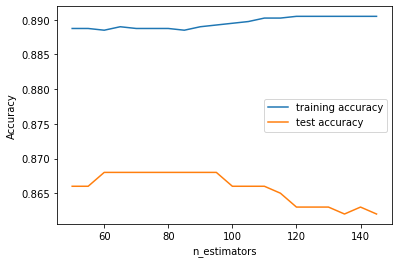

In [8]:
# xgboost case 1: tune n_estimators, 
# I tune parameters one-by-one, not by GridSearchCV so you can see clearly the effect of each parameter
# In the future, you can use this code or GridSearchCV directly.
# we tune the most important parameter n_estimators
# This is the number of trees, so it is a positive integer, can be 20 to 1000 trees
from xgboost import XGBClassifier
import time
start_time = time.time()
training_accuracy = []
test_accuracy = []

para_range = np.arange(50, 150, 5) # the last argument is the step of increment, 

for x in para_range:
    
    # build the model, the following is main function of xgb classifier and is important
    xgb = XGBClassifier(random_state=1, use_label_encoder=False, \
                        eval_metric='error', n_estimators=x, \
                        eta=0.005, max_depth=5,subsample=1, \
                        colsample_bytree=1,colsample_bylevel=1,\
                        colsample_bynode=1,\
                        gamma=0,reg_lambda=0,reg_alpha=0,\
                        min_child_weight=0)
    # same fit function to train your model based on one training dataset (no 10-fold cv)
    xgb.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(xgb.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(xgb.score(X_test, y_test))
 
print(training_accuracy)
print(test_accuracy)

plt.plot(para_range, training_accuracy, label="training accuracy")
plt.plot(para_range, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.legend()
print("--- %s seconds ---" % (time.time() - start_time))
# We can see that taining keep increasing, testing as a peak around 50
# The maximum is 0.869

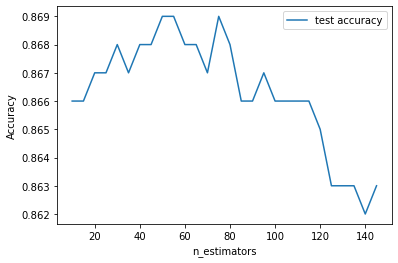

In [4]:
# Let's look at only test accuracy and so it is clearer
plt.plot(para_range, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.legend()

[0.882, 0.88375, 0.891, 0.90025, 0.91175, 0.92925, 0.94975, 0.96575]
[0.867, 0.867, 0.869, 0.868, 0.864, 0.865, 0.862, 0.864]
--- 2.1175265312194824 seconds ---


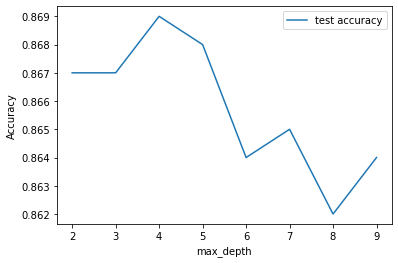

In [5]:
# xgboost case 2: tune max_depth, 
# this the max level of each tree, so it is a positive integer
# value ranges from 2 to 10, usually 4-7
start_time = time.time()
training_accuracy = []
test_accuracy = []
para_range = np.arange(2, 10, 1) # the last argument is the step of increment, 

for x in para_range:
    
    # build the model
    xgb = XGBClassifier(random_state=1, use_label_encoder=False, \
                        eval_metric='error', n_estimators=60, \
                        eta=0.1, max_depth=x,subsample=1, \
                        colsample_bytree=1,colsample_bylevel=1,\
                        colsample_bynode=1,\
                        gamma=0,reg_lambda=0,reg_alpha=0,\
                        min_child_weight=0)
    
    xgb.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(xgb.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(xgb.score(X_test, y_test))
 
print(training_accuracy)
print(test_accuracy)

# plt.plot(para_range, training_accuracy, label="training accuracy")
# let me turnoff training accuracy now and you can see testing more clearly
# training is always increasing or decreasing due to overfiting effect
plt.plot(para_range, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("max_depth")
plt.legend()
print("--- %s seconds ---" % (time.time() - start_time))
# We can see that taining keep increasing, testing at a peak at 4
# The maximum is 0.869

[0.891, 0.89, 0.88825, 0.88825, 0.88925, 0.8885, 0.888, 0.886, 0.885, 0.88325, 0.88275, 0.8825, 0.88175, 0.883, 0.88275, 0.8825, 0.88075, 0.881, 0.88125, 0.8805]
[0.869, 0.868, 0.868, 0.869, 0.868, 0.866, 0.87, 0.868, 0.867, 0.868, 0.868, 0.868, 0.868, 0.868, 0.868, 0.868, 0.867, 0.868, 0.869, 0.868]
--- 3.5200438499450684 seconds ---


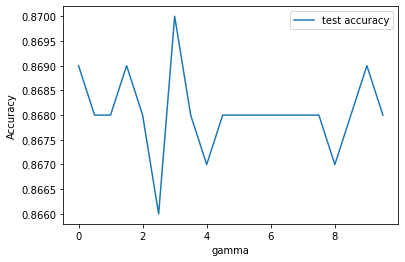

In [6]:
# xgboost case 3: tune gamma, 
# this is a regularizatoin penalty, it is a positive real number
# my experience is this number is 0 to small integer like 2.
# but sometimes I see people use 5-10.
start_time = time.time()
training_accuracy = []
test_accuracy = []
para_range = np.arange(0, 10, 0.5) # the last argument is the step of increment, 

for x in para_range:
    
    # build the model
    xgb = XGBClassifier(random_state=1, use_label_encoder=False, \
                        eval_metric='error', n_estimators=60, \
                        eta=0.1, max_depth=4,subsample=1, \
                        colsample_bytree=1,colsample_bylevel=1,\
                        colsample_bynode=1,\
                        gamma=x,reg_lambda=0,reg_alpha=0,\
                        min_child_weight=0)
    
    xgb.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(xgb.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(xgb.score(X_test, y_test))
 
print(training_accuracy)
print(test_accuracy)

# plt.plot(para_range, training_accuracy, label="training accuracy")
# let me turnoff training accuracy now and you can see testing more clearly
# training is always increasing or decreasing due to overfiting effect
plt.plot(para_range, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("gamma")
plt.legend()
print("--- %s seconds ---" % (time.time() - start_time))
# it seems to me gamma does not matter much...
# all results could be noise, but let's still use the peak at 3

[0.888, 0.8855, 0.8855, 0.88575, 0.885, 0.88475, 0.88425, 0.88425, 0.88525, 0.88425, 0.884, 0.88375, 0.8835, 0.88425, 0.88325, 0.884, 0.88325, 0.88325, 0.883, 0.88375]
[0.87, 0.868, 0.869, 0.869, 0.869, 0.868, 0.868, 0.868, 0.868, 0.868, 0.868, 0.867, 0.867, 0.867, 0.868, 0.868, 0.868, 0.868, 0.868, 0.868]
--- 3.5870234966278076 seconds ---


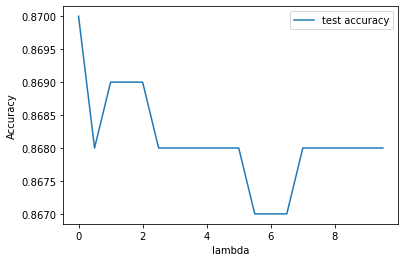

In [7]:
# xgboost case 4: tune lambda
# value is similar to gamma
start_time = time.time()
training_accuracy = []
test_accuracy = []
para_range = np.arange(0, 10, 0.5) # the last argument is the step of increment, 

for x in para_range:
    
    # build the model
    xgb = XGBClassifier(random_state=1, use_label_encoder=False, \
                        eval_metric='error', n_estimators=60, \
                        eta=0.1, max_depth=4,subsample=1, \
                        colsample_bytree=1,colsample_bylevel=1,\
                        colsample_bynode=1,\
                        gamma=3,reg_lambda=x,reg_alpha=0,\
                        min_child_weight=0)
    
    xgb.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(xgb.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(xgb.score(X_test, y_test))
 
print(training_accuracy)
print(test_accuracy)

# plt.plot(para_range, training_accuracy, label="training accuracy")
# let me turnoff training accuracy now and you can see testing more clearly
# training is always increasing or decreasing due to overfiting effect
plt.plot(para_range, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("lambda")
plt.legend()
print("--- %s seconds ---" % (time.time() - start_time))
# it seems to me given the current parameters, lambda seems decreasing
# so we set lambda=0

[0.888, 0.88575, 0.88625, 0.886, 0.8865, 0.88575, 0.8865, 0.88625, 0.885, 0.88525, 0.88475, 0.88575, 0.88575, 0.88425, 0.8845, 0.88475, 0.88475, 0.88425, 0.88375, 0.88425, 0.884, 0.8835, 0.8825, 0.88375, 0.88275, 0.8835, 0.883, 0.88325, 0.8835, 0.883]
[0.87, 0.868, 0.868, 0.868, 0.869, 0.869, 0.869, 0.869, 0.869, 0.87, 0.87, 0.87, 0.871, 0.869, 0.868, 0.868, 0.869, 0.868, 0.87, 0.87, 0.87, 0.867, 0.87, 0.869, 0.869, 0.869, 0.869, 0.87, 0.87, 0.869]
--- 7.648783445358276 seconds ---


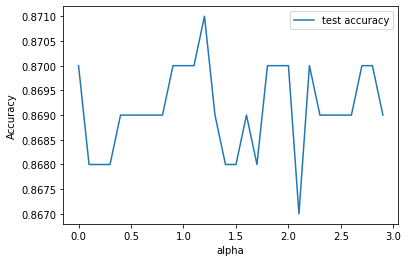

In [10]:
# xgboost case 5: tune alpha
# value is similar to gamma
start_time = time.time()
training_accuracy = []
test_accuracy = []
para_range = np.arange(0, 3, 0.1) # the last argument is the step of increment, 

for x in para_range:
    
    # build the model
    xgb = XGBClassifier(random_state=1, use_label_encoder=False, \
                        eval_metric='error', n_estimators=60, \
                        eta=0.1, max_depth=4,subsample=1, \
                        colsample_bytree=1,colsample_bylevel=1,\
                        colsample_bynode=1,\
                        gamma=3,reg_lambda=0,reg_alpha=x,\
                        min_child_weight=0)
    
    xgb.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(xgb.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(xgb.score(X_test, y_test))
 
print(training_accuracy)
print(test_accuracy)

# plt.plot(para_range, training_accuracy, label="training accuracy")
# let me turnoff training accuracy now and you can see testing more clearly
# training is always increasing or decreasing due to overfiting effect
plt.plot(para_range, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("alpha")
plt.legend()
print("--- %s seconds ---" % (time.time() - start_time))
# it seems to me alpha is bumpy and no clear trend
# The trouble of manual tuning is gamma,lambda,alpha may need to be tuned together
# all these 3 are regularization parameters, just different functions, like L1 L2...etc.

[0.875, 0.87825, 0.881, 0.88225, 0.88475, 0.884, 0.886, 0.88675, 0.8855, 0.886, 0.887, 0.8875, 0.8865, 0.8855, 0.88725, 0.88775, 0.888, 0.88575]
[0.843, 0.853, 0.858, 0.866, 0.865, 0.866, 0.865, 0.864, 0.869, 0.866, 0.867, 0.865, 0.869, 0.867, 0.865, 0.867, 0.867, 0.87]
--- 2.909022569656372 seconds ---


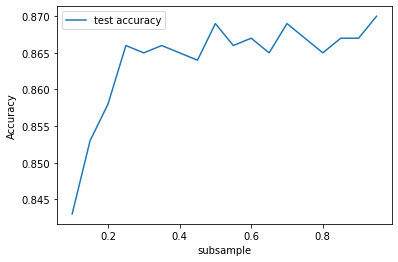

In [9]:
# xgboost case 6: tune subsample (subsampling of rows)
# this is the proportion to sample rows
# this is a percentage%, (0,1] and 0 does not make sense, 1 is common
start_time = time.time()
training_accuracy = []
test_accuracy = []
para_range = np.arange(0.1, 1, 0.05) # the last argument is the step of increment, 

for x in para_range:
    
    # build the model
    xgb = XGBClassifier(random_state=1, use_label_encoder=False, \
                        eval_metric='error', n_estimators=60, \
                        eta=0.1, max_depth=4,subsample=x, \
                        colsample_bytree=1,colsample_bylevel=1,\
                        colsample_bynode=1,\
                        gamma=3,reg_lambda=0,reg_alpha=0,\
                        min_child_weight=0)
    
    xgb.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(xgb.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(xgb.score(X_test, y_test))
 
print(training_accuracy)
print(test_accuracy)

# plt.plot(para_range, training_accuracy, label="training accuracy")
# let me turnoff training accuracy now and you can see testing more clearly
# training is always increasing or decreasing due to overfiting effect
plt.plot(para_range, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("subsample")
plt.legend()
print("--- %s seconds ---" % (time.time() - start_time))
# it seems to me subsample by rows is increasing

[0.8825, 0.8825, 0.8825, 0.8825, 0.8825, 0.8825, 0.88475, 0.88475, 0.88475, 0.88475, 0.88625, 0.88625, 0.88625, 0.88625, 0.8865, 0.8865, 0.8865, 0.8865]
[0.869, 0.869, 0.869, 0.869, 0.869, 0.869, 0.868, 0.868, 0.868, 0.868, 0.869, 0.869, 0.869, 0.869, 0.867, 0.867, 0.867, 0.867]
--- 3.0232393741607666 seconds ---


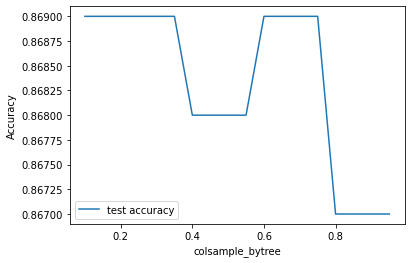

In [10]:
# xgboost case 7: tune colsample_bytree (subsampling of columns ast tree)
# this is a percentage%, (0,1] and 0 does not make sense, 1 is common
start_time = time.time()
training_accuracy = []
test_accuracy = []
para_range = np.arange(0.1, 1, 0.05) # the last argument is the step of increment, 

for x in para_range:
    
    # build the model
    xgb = XGBClassifier(random_state=1, use_label_encoder=False, \
                        eval_metric='error', n_estimators=60, \
                        eta=0.1, max_depth=4,subsample=1, \
                        colsample_bytree=x,colsample_bylevel=1,\
                        colsample_bynode=1,\
                        gamma=3,reg_lambda=0,reg_alpha=0,\
                        min_child_weight=0)
    
    xgb.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(xgb.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(xgb.score(X_test, y_test))
 
print(training_accuracy)
print(test_accuracy)

# plt.plot(para_range, training_accuracy, label="training accuracy")
# let me turnoff training accuracy now and you can see testing more clearly
# training is always increasing or decreasing due to overfiting effect
plt.plot(para_range, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("colsample_bytree")
plt.legend()
print("--- %s seconds ---" % (time.time() - start_time))
# it seems to me colsample_bytree by rows is decreasing but effect is small
# One good choice could be 0.75 but effect is very small 0.867 and 0.869

[0.88225, 0.88225, 0.88225, 0.88225, 0.88225, 0.88225, 0.88225, 0.88225, 0.88225, 0.88225, 0.88225, 0.88225, 0.88425, 0.88425, 0.88425, 0.88425, 0.88425, 0.88425]
[0.868, 0.868, 0.868, 0.868, 0.868, 0.868, 0.868, 0.868, 0.868, 0.868, 0.868, 0.868, 0.866, 0.866, 0.866, 0.866, 0.866, 0.866]
--- 2.989687204360962 seconds ---


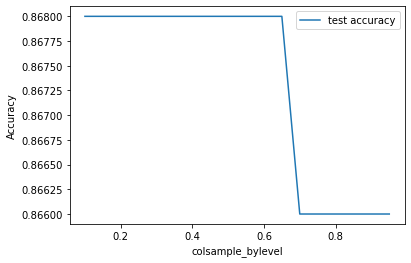

In [11]:
# xgboost case 8: tune colsample_bylevel (subsampling of columns at level)
# this is a percentage%, (0,1] and 0 does not make sense, 1 is common
start_time = time.time()
training_accuracy = []
test_accuracy = []
para_range = np.arange(0.1, 1, 0.05) # the last argument is the step of increment, 

for x in para_range:
    
    # build the model
    xgb = XGBClassifier(random_state=1, use_label_encoder=False, \
                        eval_metric='error', n_estimators=60, \
                        eta=0.1, max_depth=4,subsample=1, \
                        colsample_bytree=0.7,colsample_bylevel=x,\
                        colsample_bynode=1,\
                        gamma=3,reg_lambda=0,reg_alpha=0,\
                        min_child_weight=0)
    
    xgb.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(xgb.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(xgb.score(X_test, y_test))
 
print(training_accuracy)
print(test_accuracy)

# plt.plot(para_range, training_accuracy, label="training accuracy")
# let me turnoff training accuracy now and you can see testing more clearly
# training is always increasing or decreasing due to overfiting effect
plt.plot(para_range, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("colsample_bylevel")
plt.legend()
print("--- %s seconds ---" % (time.time() - start_time))
# it seems to me colsample_bylevel is decreasing but effect is small
# also, somehow results are worse now... so I will increase the sampling rate a bit


[0.884, 0.884, 0.884, 0.884, 0.884, 0.884, 0.884, 0.884, 0.884, 0.884, 0.884, 0.884, 0.88575, 0.88575, 0.88575, 0.88575, 0.88575, 0.88575]
[0.867, 0.867, 0.867, 0.867, 0.867, 0.867, 0.867, 0.867, 0.867, 0.867, 0.867, 0.867, 0.868, 0.868, 0.868, 0.868, 0.868, 0.868]
--- 2.8912837505340576 seconds ---


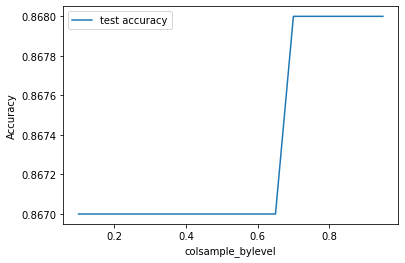

In [12]:
# xgboost case 9: tune colsample_bynode (subsampling of columns at nodes)
# this is a percentage%, (0,1] and 0 does not make sense, 1 is common
start_time = time.time()
training_accuracy = []
test_accuracy = []
para_range = np.arange(0.1, 1, 0.05) # the last argument is the step of increment, 

for x in para_range:
    
    # build the model
    xgb = XGBClassifier(random_state=1, use_label_encoder=False, \
                        eval_metric='error', n_estimators=60, \
                        eta=0.1, max_depth=4,subsample=1, \
                        colsample_bytree=0.8,colsample_bylevel=0.8,\
                        colsample_bynode=x,\
                        gamma=3,reg_lambda=0,reg_alpha=0,\
                        min_child_weight=0)
    
    xgb.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(xgb.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(xgb.score(X_test, y_test))
 
print(training_accuracy)
print(test_accuracy)

# plt.plot(para_range, training_accuracy, label="training accuracy")
# let me turnoff training accuracy now and you can see testing more clearly
# training is always increasing or decreasing due to overfiting effect
plt.plot(para_range, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("colsample_bylevel")
plt.legend()
print("--- %s seconds ---" % (time.time() - start_time))
# effect is very small

[0.88525, 0.88625, 0.88425, 0.8845, 0.8835, 0.884, 0.88275, 0.8835, 0.88225, 0.88375, 0.883, 0.883, 0.88225, 0.88275, 0.88325, 0.88275, 0.88375, 0.8835, 0.88325, 0.8825, 0.883, 0.88225, 0.883, 0.882, 0.8825, 0.88225, 0.88275, 0.8825, 0.8825, 0.88325]
[0.867, 0.869, 0.869, 0.867, 0.869, 0.869, 0.867, 0.867, 0.868, 0.868, 0.869, 0.868, 0.869, 0.87, 0.868, 0.868, 0.867, 0.867, 0.867, 0.867, 0.867, 0.868, 0.868, 0.868, 0.868, 0.868, 0.866, 0.868, 0.868, 0.868]
--- 4.779727458953857 seconds ---


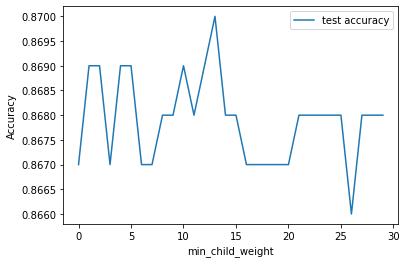

In [13]:
# xgboost case 10: tune min_child_weight
# This is the minimum number of rows at leaf node.
# it is a positive integer? usually small integer
# from my experience, not so important
start_time = time.time()
training_accuracy = []
test_accuracy = []
para_range = np.arange(0, 30, 1) # the last argument is the step of increment, 

for x in para_range:
    
    # build the model
    xgb = XGBClassifier(random_state=1, use_label_encoder=False, \
                        eval_metric='error', n_estimators=60, \
                        eta=0.1, max_depth=4,subsample=1, \
                        colsample_bytree=0.8,colsample_bylevel=0.8,\
                        colsample_bynode=1,\
                        gamma=3,reg_lambda=0,reg_alpha=0,\
                        min_child_weight=x)
    
    xgb.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(xgb.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(xgb.score(X_test, y_test))
 
print(training_accuracy)
print(test_accuracy)

# plt.plot(para_range, training_accuracy, label="training accuracy")
# let me turnoff training accuracy now and you can see testing more clearly
# training is always increasing or decreasing due to overfiting effect
plt.plot(para_range, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("min_child_weight")
plt.legend()
print("--- %s seconds ---" % (time.time() - start_time))
# effect is small, looks like we should not set too high

[0.8815, 0.88125, 0.8815, 0.882, 0.88325, 0.8825, 0.883, 0.88375, 0.88325, 0.88375, 0.883, 0.8835, 0.88375, 0.884, 0.88325, 0.88375, 0.88325, 0.88425, 0.8835, 0.88425, 0.8835, 0.88375, 0.88425, 0.88425, 0.884, 0.88375, 0.88375, 0.88475, 0.885, 0.8845, 0.88375, 0.88325, 0.88625, 0.88475, 0.885, 0.88525, 0.885, 0.88475, 0.886, 0.88625, 0.88625, 0.88625, 0.88675, 0.88525, 0.88575, 0.88575, 0.886, 0.88525, 0.8865, 0.888, 0.88825, 0.8875, 0.88725, 0.887, 0.887, 0.88725, 0.88925, 0.888, 0.88825, 0.89025, 0.8895, 0.88925, 0.89075, 0.8895, 0.8915, 0.888, 0.89275, 0.89, 0.8925, 0.88675, 0.88975, 0.8915, 0.889, 0.8905, 0.8935, 0.88875, 0.89125, 0.89175, 0.897, 0.8905, 0.89025, 0.893, 0.89475, 0.89275, 0.8935, 0.89725, 0.89375, 0.8935, 0.89225, 0.892, 0.89825, 0.893, 0.8985, 0.89525, 0.896, 0.8975, 0.8965, 0.89575, 0.89825, 0.89875, 0.89325, 0.9005, 0.894, 0.89225, 0.895, 0.9005, 0.8965, 0.90025, 0.90025, 0.89625, 0.899, 0.89525, 0.89825, 0.9045, 0.89625, 0.896, 0.9035, 0.899, 0.9015, 0.901, 0.89

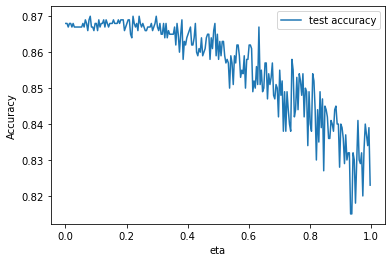

In [14]:
# xgboost case 11: tune eta... This is an important parameter!!!
# actually eta and n_estimators are very important but need to tune together
# max_depth has effect but easier to tune and narrow down to 1 value
# eta is a positive real number between (0,1) and too close to 1 is not good
# small eta means you are using a model closer to random forest
# larger eta means you are using a model closer to ada boost
start_time = time.time()
training_accuracy = []
test_accuracy = []
para_range = np.arange(0.001, 1, 0.004) # the last argument is the step of increment, 

for x in para_range:
    
    # build the model
    xgb = XGBClassifier(random_state=1, use_label_encoder=False, \
                        eval_metric='error', n_estimators=60, \
                        eta=x, max_depth=4,subsample=1, \
                        colsample_bytree=0.8,colsample_bylevel=0.8,\
                        colsample_bynode=1,\
                        gamma=3,reg_lambda=0,reg_alpha=0,\
                        min_child_weight=3)
    
    xgb.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(xgb.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(xgb.score(X_test, y_test))
 
print(training_accuracy)
print(test_accuracy)

# plt.plot(para_range, training_accuracy, label="training accuracy")
# let me turnoff training accuracy now and you can see testing more clearly
# training is always increasing or decreasing due to overfiting effect
plt.plot(para_range, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("eta")
plt.legend()
print("--- %s seconds ---" % (time.time() - start_time))
# we can observe that given the current number of trees,
# larger eta is not good, the accuracy is worse and aslo unstable
# We should try smaller eta and tune the number of trees, This is also my own practice.

[0.88175, 0.88175, 0.8815, 0.88175, 0.88175, 0.8815, 0.8815, 0.88175, 0.88175, 0.8815, 0.88175, 0.88175, 0.8815, 0.8815, 0.88175, 0.8815, 0.8815, 0.8815, 0.88175, 0.88175, 0.88175, 0.88225, 0.88175, 0.88175, 0.882, 0.88225, 0.8825, 0.88225, 0.8825, 0.88275, 0.8825, 0.8825, 0.88275, 0.88275, 0.883, 0.8835, 0.883, 0.8835, 0.883, 0.8835, 0.8835, 0.8835, 0.883, 0.883, 0.88325, 0.88325, 0.883, 0.8835, 0.8835, 0.8835, 0.8835, 0.8835, 0.883, 0.883, 0.883, 0.883, 0.88275, 0.88275, 0.88275, 0.88275, 0.8825, 0.8825, 0.8825, 0.88275, 0.88275, 0.88275, 0.88275, 0.88275, 0.8825, 0.8825, 0.8825, 0.883, 0.883, 0.883, 0.883, 0.883, 0.883, 0.883, 0.883, 0.883, 0.883, 0.883, 0.883, 0.883, 0.883, 0.883, 0.883, 0.883, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.88325, 0.883, 0.883,

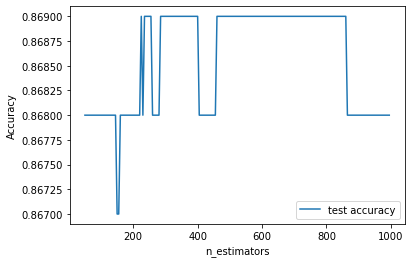

In [15]:
start_time = time.time()
training_accuracy = []
test_accuracy = []
para_range = np.arange(50, 1000, 5) # the last argument is the step of increment, 

for x in para_range:
    
    # build the model
    xgb = XGBClassifier(random_state=1, use_label_encoder=False, \
                        eval_metric='error', n_estimators=x, \
                        eta=0.001, max_depth=4,subsample=1, \
                        colsample_bytree=0.8,colsample_bylevel=0.8,\
                        colsample_bynode=1,\
                        gamma=3,reg_lambda=0,reg_alpha=0,\
                        min_child_weight=3)
    
    xgb.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(xgb.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(xgb.score(X_test, y_test))
 
print(training_accuracy)
print(test_accuracy)

# plt.plot(para_range, training_accuracy, label="training accuracy")
# let me turnoff training accuracy now and you can see testing more clearly
# training is always increasing or decreasing due to overfiting effect
plt.plot(para_range, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.legend()
print("--- %s seconds ---" % (time.time() - start_time))
# now the speed is slower, notice that you need to use more trees.
# but the good news is the number of trees does not have that strong effect
# there is a wider range of n_estimators give you similar results.
# you can compare with the very first case when we set eta=0.1
# I personally like using smaller eta, which is not based on science
# we can exchange ideas if you have different opinion.